In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

# Transformation to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the MNIST dataset
full_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Splitting the dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=100, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

In [2]:
# Inspecting the train dataset
train_data_iter = iter(train_loader)
train_images, train_labels = next(train_data_iter) 
print(f"Train Images Shape: {train_images.shape}")
print(f"Train Labels Shape: {train_labels.shape}")
print("-----------------------------------------")

# Inspecting the val dataset
val_data_iter = iter(val_loader)
val_images, val_labels = next(val_data_iter) 
print(f"Validation Images Shape: {val_images.shape}")
print(f"Validation Labels Shape: {val_labels.shape}")
print("-----------------------------------------")

# Inspecting the test dataset
test_data_iter = iter(test_loader)
test_images, test_labels = next(test_data_iter) 
print(f"Test Images Shape: {test_images.shape}")
print(f"Test Labels Shape: {test_labels.shape}")


Train Images Shape: torch.Size([100, 1, 28, 28])
Train Labels Shape: torch.Size([100])
-----------------------------------------
Validation Images Shape: torch.Size([100, 1, 28, 28])
Validation Labels Shape: torch.Size([100])
-----------------------------------------
Test Images Shape: torch.Size([100, 1, 28, 28])
Test Labels Shape: torch.Size([100])


In [3]:
# Define the CNN Without Dropout
class CNNWithoutDropout(nn.Module):
   def __init__(self):
       super(CNNWithoutDropout, self).__init__()
       self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
       self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
       self.fc1 = nn.Linear(64 * 7 * 7, 128)
       self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
       x = self.pool(torch.relu(self.conv1(x)))
       x = self.pool(torch.relu(self.conv2(x)))
       x = x.view(-1, 64 * 7 * 7)
       x = torch.relu(self.fc1(x))
       x = self.fc2(x)
       return x

model_without_dropout = CNNWithoutDropout()
model_without_dropout = model_without_dropout.to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer_without_dropout = optim.SGD(model_without_dropout.parameters(), lr=0.01, momentum=0.9)

In [4]:
def train_validate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            # Move inputs and labels to GPU
            images, labels = images.to('cuda'), labels.to('cuda')

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_accuracy = 100 * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation Phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                # Move inputs and labels to GPU
                images, labels = images.to('cuda'), labels.to('cuda')

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    return train_losses, val_losses, train_accuracies, val_accuracies


In [5]:
train_losses_without_dropout, val_losses_without_dropout, train_accuracies_without_dropout, val_accuracies_without_dropout = train_validate_model(
   model_without_dropout, train_loader, val_loader, criterion, optimizer_without_dropout
)


Epoch [1/20], Loss: 0.3868, Accuracy: 88.51%, Val Loss: 0.0932, Val Accuracy: 97.10%
Epoch [2/20], Loss: 0.0710, Accuracy: 97.79%, Val Loss: 0.0703, Val Accuracy: 97.96%
Epoch [3/20], Loss: 0.0508, Accuracy: 98.44%, Val Loss: 0.0507, Val Accuracy: 98.42%
Epoch [4/20], Loss: 0.0384, Accuracy: 98.77%, Val Loss: 0.0489, Val Accuracy: 98.36%
Epoch [5/20], Loss: 0.0307, Accuracy: 99.02%, Val Loss: 0.0405, Val Accuracy: 98.91%
Epoch [6/20], Loss: 0.0264, Accuracy: 99.17%, Val Loss: 0.0451, Val Accuracy: 98.63%
Epoch [7/20], Loss: 0.0219, Accuracy: 99.28%, Val Loss: 0.0364, Val Accuracy: 98.97%
Epoch [8/20], Loss: 0.0183, Accuracy: 99.41%, Val Loss: 0.0382, Val Accuracy: 98.88%
Epoch [9/20], Loss: 0.0149, Accuracy: 99.56%, Val Loss: 0.0334, Val Accuracy: 99.10%
Epoch [10/20], Loss: 0.0116, Accuracy: 99.64%, Val Loss: 0.0354, Val Accuracy: 98.96%
Epoch [11/20], Loss: 0.0104, Accuracy: 99.67%, Val Loss: 0.0367, Val Accuracy: 99.09%
Epoch [12/20], Loss: 0.0086, Accuracy: 99.75%, Val Loss: 0.0365

In [6]:
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            # Move inputs and labels to GPU
            images, labels = images.to('cuda'), labels.to('cuda')

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

accuracy_without_dropout = evaluate_model(model_without_dropout, test_loader, criterion)
print(f'Accuracy of the model without dropout on the test images: {accuracy_without_dropout:.2f}%')


Accuracy of the model without dropout on the test images: 99.25%


## WITH DROPOUT

In [7]:
# Define the CNN With Dropout
class CNNWithDropout(nn.Module):
   def __init__(self):
       super(CNNWithDropout, self).__init__()
       self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
       self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
       self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
       self.dropout = nn.Dropout(p=0.5)  # Dropout layer with 50% probability
       self.fc1 = nn.Linear(64 * 7 * 7, 128)
       self.fc2 = nn.Linear(128, 10)

   def forward(self, x):
       x = self.pool(torch.relu(self.conv1(x)))
       x = self.pool(torch.relu(self.conv2(x)))
       x = x.view(-1, 64 * 7 * 7)
       x = self.dropout(torch.relu(self.fc1(x)))  # Apply dropout after ReLU activation
       x = self.fc2(x)
       return x

model_with_dropout = CNNWithDropout()
model_with_dropout = model_with_dropout.to('cuda')

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer_with_dropout = optim.SGD(model_with_dropout.parameters(), lr=0.01, momentum=0.9)

In [9]:
train_losses_with_dropout, val_losses_with_dropout, train_accuracies_with_dropout, val_accuracies_with_dropout = train_validate_model(
   model_with_dropout, train_loader, val_loader, criterion, optimizer_with_dropout
)


Epoch [1/20], Loss: 0.4664, Accuracy: 85.51%, Val Loss: 0.0982, Val Accuracy: 96.97%
Epoch [2/20], Loss: 0.1156, Accuracy: 96.56%, Val Loss: 0.0614, Val Accuracy: 98.14%
Epoch [3/20], Loss: 0.0876, Accuracy: 97.36%, Val Loss: 0.0487, Val Accuracy: 98.58%
Epoch [4/20], Loss: 0.0704, Accuracy: 97.90%, Val Loss: 0.0454, Val Accuracy: 98.62%
Epoch [5/20], Loss: 0.0613, Accuracy: 98.21%, Val Loss: 0.0438, Val Accuracy: 98.62%
Epoch [6/20], Loss: 0.0537, Accuracy: 98.42%, Val Loss: 0.0456, Val Accuracy: 98.61%
Epoch [7/20], Loss: 0.0478, Accuracy: 98.55%, Val Loss: 0.0378, Val Accuracy: 98.96%
Epoch [8/20], Loss: 0.0441, Accuracy: 98.62%, Val Loss: 0.0351, Val Accuracy: 99.03%
Epoch [9/20], Loss: 0.0369, Accuracy: 98.84%, Val Loss: 0.0368, Val Accuracy: 98.98%
Epoch [10/20], Loss: 0.0350, Accuracy: 98.92%, Val Loss: 0.0363, Val Accuracy: 99.01%
Epoch [11/20], Loss: 0.0346, Accuracy: 98.92%, Val Loss: 0.0330, Val Accuracy: 99.10%
Epoch [12/20], Loss: 0.0315, Accuracy: 99.03%, Val Loss: 0.0387

In [10]:
accuracy_with_dropout = evaluate_model(model_with_dropout, test_loader, criterion)
print(f'Accuracy of the model with dropout on the test images: {accuracy_with_dropout:.2f}%')

Accuracy of the model with dropout on the test images: 99.27%


# Comparing the effect of dropout in neural networks


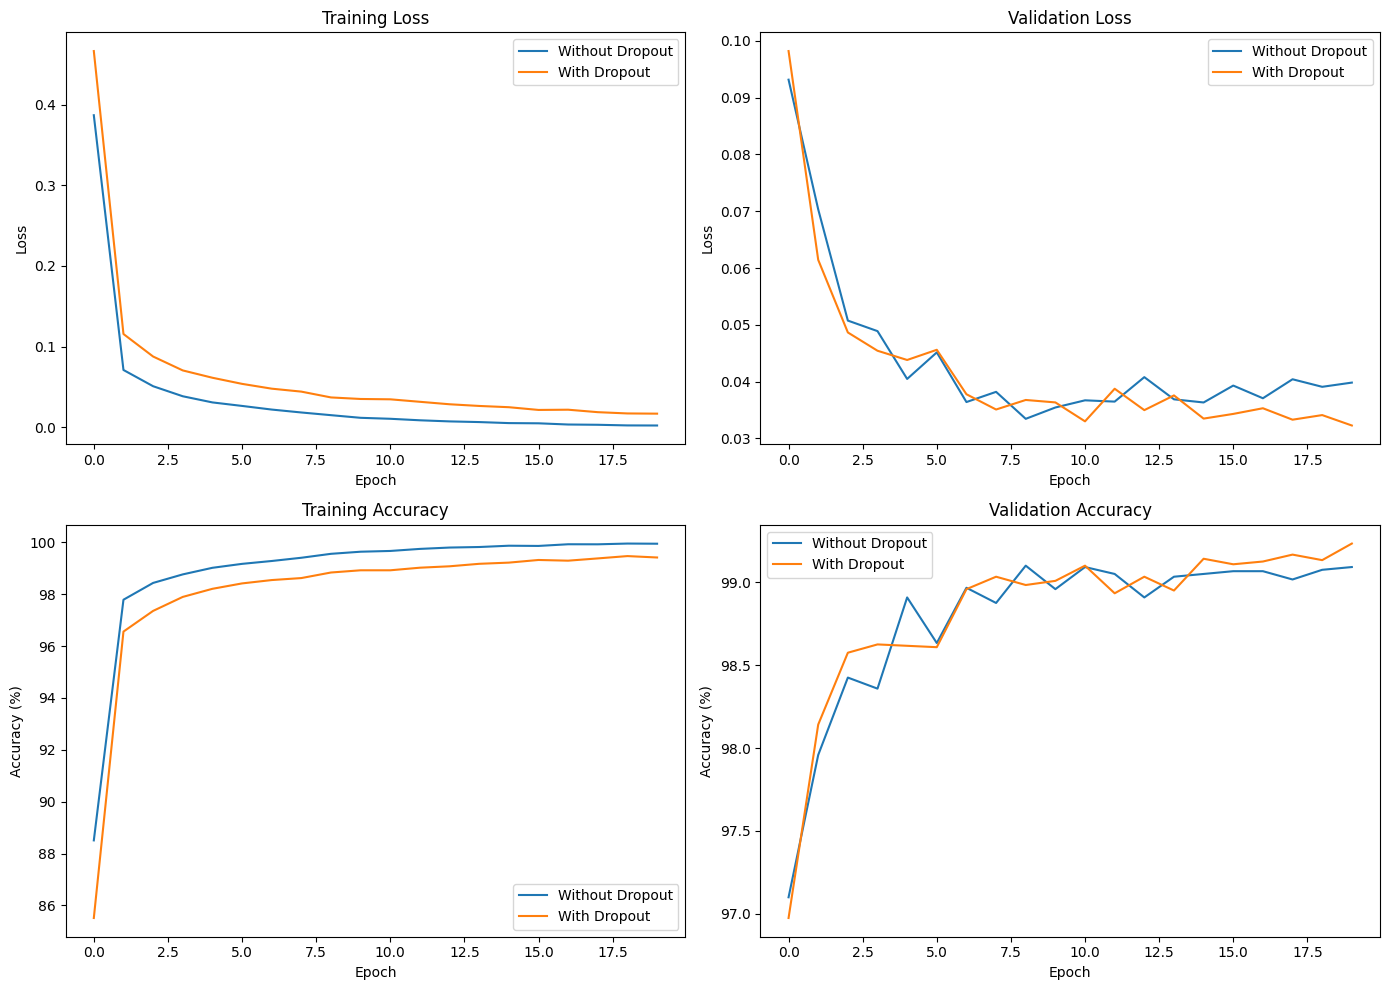

In [11]:
# Plotting the Results
plt.figure(figsize=(14, 10))

# Plot training loss
plt.subplot(2, 2, 1)
plt.plot(train_losses_without_dropout, label='Without Dropout')
plt.plot(train_losses_with_dropout, label='With Dropout')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot validation loss
plt.subplot(2, 2, 2)
plt.plot(val_losses_without_dropout, label='Without Dropout')
plt.plot(val_losses_with_dropout, label='With Dropout')
plt.title('Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot training accuracy
plt.subplot(2, 2, 3)
plt.plot(train_accuracies_without_dropout, label='Without Dropout')
plt.plot(train_accuracies_with_dropout, label='With Dropout')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

# Plot validation accuracy
plt.subplot(2, 2, 4)
plt.plot(val_accuracies_without_dropout, label='Without Dropout')
plt.plot(val_accuracies_with_dropout, label='With Dropout')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()
